# Notebook 4: Blitztein and Diaconis (2011) Network Simulation
#### Econometric Methods for Networks
#### _Singapore Management University (SMU) May 29th to June 1st, 2017_
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
<br>
<br>
This is the fourth in a series of iPython Jupyter notebooks initially designed to accompany a series of instructional lectures given at the Singapore Management University (SMU) from May 29th to June 1st, 2017. The scripts in this edition of the course notebook have been updated to correctly execute in Python 3.6.1 The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.
<br>
<br>
This notebook provides an implementation of the Blitztein and Diaconis (2011) method for constucting uniform random draws from the set of all adjacency matrices with fixed degree sequences. This code was initially derived from an R implementation by Joseph Blitztein available at http://www.people.fas.harvard.edu/~blitz/Site/Research_files/GraphAlgorithmR.txt. Seonjoo Min provided an initial translation Joseph Blitztein's implementation to Python. What appears in this notebook is a revision of this initial translation to take advantage of additional Python functionality (e.g., routines available in the _networkx_ package). I am also grateful to Andrin Pelican for identifying some errors in an earlier version of this notebook.

In [1]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Importing necessary modules
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
import networkx as nx

In [2]:
# Directory where graphics files will be saved
graphics = '/Users/bgraham/Dropbox/Research/Networks/Networks_Book/Graphics/'

This first snippet of code defines all the functions needed to implement the Blitzstein and Diaconis (2011) procedure. As noted above this code follows that of Joseph Blitzstein closely. Changes mostly incorporate extra Python functionality. For example the Erodos-Gallais graphic integer sequence check is available in _networkx_ and hence doesn't need to be hand-coded.

In [6]:
def random_graph_with_fixed_degree(degrees):
    
    """
    Generate random graph with given degree sequence using
    the method of Blitzstein and Diaconis (2011, Internet Math).
    
    INPUTS:
    -------
    degrees      : target degree sequence (*list* of integers)
    
    OUTPUT:
    -------
    log_G_prob   : ex ante log probability of realized sequence of chosen edges
                   (This term is used to construct the importance weights.)
    edges        : edge list associated with simulated graph
    
    CALLS:
    ------
    ...is_graphical()... from networkx package
    
    NOTES: Uses several utility functions that are defined below within
           the body of the main function. Method is as described in
           Blitzstein and Diaconis (2011, Internet Mathematics). This
           code was developed by adapting R code by Joseph Blitzstein.
    
    """
    
    #--------------------------------------------------------#
    #- DEFINE SOME UTILITY FUNCTIONS THAT ARE CALLED BY THE -#
    #- MAIN FUNCTION                                        -#
    #--------------------------------------------------------#
    
    def subtract_graphical(degrees, i, j):
    
        """
        Tests whether a residual degree sequence associated with
        degree sequence "degrees" is graphical after adding an edge between 
        vertices i and j.
    
        INPUTS:
        -------
        degrees      : 1d numpy array integers with current agent degrees
        i, j         : agents who are candidates to be linked (integers)
    
        OUTPUT:
        -------
        True or False boolean according to whether residual degree sequence is graphical 
        after the candidate edge is added
    
        CALLS:
        ------
        ...is_valid_degree_sequence_erdos_gallai()... from networkx package
                   
        """
        
        resid_degrees    = copy.copy(degrees)     # Make copy to avoid modifying the degree
        resid_degrees[i] = resid_degrees[i] - 1   # sequence permanently since it is mutable
        resid_degrees[j] = resid_degrees[j] - 1   
    
        return nx.is_graphical(resid_degrees.tolist(), method='eg')


    def list_candidates(i, degrees, edges, N):
    
        """
        Constructs a list of candidate vertices to which an vertex/agent may be connected without
        generating a residual degree sequence which is non-graphical.
    
        INPUTS:
        -------
        i            : agent/vertex who is to be linked with some other agent (integer)
        degrees      : current (residual) degree sequence (1d numpy array integers)
        edges        : edge list [(1,2),(5,6)...] 
        N            : number vertices in graph (integer)
    
        OUTPUT:
        -------
        candidates   : list of other agents to which vertex may validly be matched
    
        CALLS:
        ------
        ...is_valid_degree_sequence_erdos_gallai()... from networkx package    
        ...subtract_graphical()... 
         
        """
    
        if not nx.is_graphical(degrees.tolist(), method='eg'):
            print("Error: Non-graphical residual degree sequence input in list_candidates().")
            return None
    
        candidates = []      # Initialize list of allowable candidates 
    
        # form list of candidates to which the vertex i may be linked while
        # keeping the residual degree sequence graphical
    
        for j in range(0,N):
            # for each j first check whether j!=i and whether (i,j) or (j,i) is already an edge
            if (i != j) and ((i,j) not in edges) and ((j,i) not in edges): 
                # if first condition holds, check for graphicality of residual degree sequence
                if subtract_graphical(degrees, i, j):
                    # if second condition holds then add the edge to candidate list
                    candidates.append(j) 
        
        return candidates                
    
    def connect_vertex(i, degrees, edges, N):
    
        """
        Connect vertex i to another agent at random from a list of candidates
        such that the new edge will not produce a non-graphical residual degree
        sequence. Note both "degrees" and "edges" are updated by this function.
    
    
        INPUTS:
        -------
        i            : agent who is to be linked with some other agent (integer)
        degrees      : residual degree sequence (1d numpy array integers)
        edges        : edge list [(1,2),(5,6)...]
        N            : number vertices in graph (integer)
    
        OUTPUT:
        -------
        Returns the probability with which the chosen partner was selected.
    
        CALLS:
        ------
        ...list_candidates()...
    
        """
    
        candidates     = list_candidates(i, degrees, edges, N)  # get list of candidate partners
        num_candidates = len(candidates)                        # count number of canidates
            
        if not candidates:
            print("Error: Candidate list is empty.")
            return None
               
        # use fancy indexing to construct numpy 1d array of candidates' residual degrees
        candidate_degrees = degrees[candidates] 
    
        # compute selection probability for each j in candidate list
        p = (candidate_degrees / np.sum(candidate_degrees))   
    
        # choose random candidate based on selection probabilities
        j = np.random.choice(candidates,1,False,p)[0] 
       
        # update residual degree sequence and add (i,j) to the edge list
        degrees[i] = degrees[i] - 1                        
        degrees[j] = degrees[j] - 1
        edges.append((i,j))                  
    
        # return selection probability for chosen edge
        # NOTE: candidates.index(j) returns index of vertex j in candidates list
        
        # Uncomment the code below if you wish to see how edges are added to the graph sequentially
        #print("")
        #print("Residual degree sequence: ")
        #print(degrees)
        #print("")
        #print("Current edge list")
        #print(edges)
        
        
        return p[candidates.index(j)]

    def connect_vertex_completely(i, degrees, edges, N):
    
        """
        This function keeps randomly adding edges to a vertex until its residual degree 
        sequence is zero. Note both "degrees" and "edges" are updated by this function.
    
        INPUTS:
        -------
        i            : agent who is to be linked with some other agent (integer)
        degrees      : residual degree sequence (1d numpy array integers)
        edges        : edge list [(1,2),(5,6)...] 
        N            : number vertices in graph (integer)
    
        OUTPUT:
        -------
        p_i          : probability associated with a particular rooted network
    
        CALLS:
        ------
        ...connect_vertex()...
    
        """
    
        # add first edge to vertex i and return its probability
        p_i = connect_vertex(i, degrees, edges, N) 
    
        # add remaining edges to i until is residual degree sequence is zero
        # build up overall probability of particular rooted network (conditional on
        # residual degree sequence) along the way
        while degrees[i] > 0:                      
            p_i *= connect_vertex(i, degrees, edges, N)
        
        return p_i

    #--------------------------------------------------------#
    #- START OF MAIN BODY OF FUNCTION                       -#
    #--------------------------------------------------------#

    # COMMENT: the nx.is_graphical() only
    #          takes list input. The rest of the function prefers
    #          a 1d numpy integer array.
    
    if not nx.is_graphical(degrees, method='eg'):
        print("Error: Non-graphical degree sequence input in random_graph_with_fixed_degree().")
        return [None, None]
    
    N       = len(degrees)                     # number of agents or vertices in network
    degrees = np.array(degrees, dtype = int)   # copy degree sequence into numpy 1d array
    
    # the ex ante that a particular graph is chosen by the algorithm equals
    # the probability that a particular sequence of edges is chosen times the
    # number of different ways that edge set could be chosen
    
    # initialize probability of simulated network
    log_G_prob  = 0    # initialize log_G_prob (= log(sigma*c) + scaling_adj) selection probability 
    edges       = []   # initialize edge list
    
    # find initial vertex with smallest positive residual degree
    try:
        i        = list(degrees).index(np.min(degrees[degrees>0]))       
        degree_i = degrees[i]
    except:
        degree_i = 0                    
    
    # keep adding edges to graph until residual degree sequence is zero
    while degree_i>0: 
        # numbers of ways current batch of edges could have been added
        orders_i = np.math.factorial(degree_i) 
        
        # add all needed edges to i and calculate probability of chosen sequence
        # NOTE: edge list and residual degree sequence should be update automatically
        p_i      = connect_vertex_completely(i, degrees, edges, N)
        
        # update ex ante probability of current graph 
        # NOTE: compute sum of log probabilities to help avoid underflow issues  
        log_G_prob  += np.log(p_i*orders_i)
        
        # find new vertex with smallest positive residual degree
        try:
            i        = list(degrees).index(np.min(degrees[degrees>0]))       
            degree_i = degrees[i]
        except:
            degree_i = 0
    
    return [log_G_prob, edges]
  
def simulate_random_graph_with_fixed_degree(degrees, S):
    
    """
    Generates random graphs with degree sequence "degrees" and combines the results with 
    importance weights to estimate the number of graphs with degree sequence "degrees". 
       
    INPUTS:
    -------
    degrees      : target degree sequence (*list* of integers)
    S            : number of simulated graphs to generate (integer)
    
    OUTPUT:
    -------
    graphs                   : list of S edge lists for each simulated graph
    stb_iwgts                : list of stabilized iwgts = iwgts / sum(iwgts)
                               (can be used to estimate expectations; such as average transitivity)
    iwgts                    : list of S importance weuights (not stabilized)
    estimated_size_of_set    : estimated number of graphs with degree sequence equal to "degrees" 
    estimated_size_of_set_se : standard error of above
    
    NOTE: These last three outputs will be set equal to "None" if
          any elements of iwgt evaluate to infinity due to
          underflow issues. This can happen for large graphs.
          In such cases the size of the set can't be precisely
          estimated, but the stabilized weights can be used
          to estimate expectations and so on.] 
    
    CALLS:
    ------
    ...random_graph_with_fixed_degree()...
    
    """
    
    # initialize list of log probability weights and edge lists
    log_G_probs  = []
    graphs = []
    
    # count number of agents/vertices with non-zero degree
    N_pos_degree = np.count_nonzero(degrees)
    
    for i in range(0,S):
        
        start = time.time()
        
        [log_G_prob, edges] = random_graph_with_fixed_degree(degrees)
    
        # add log probability weight and edge list to relevant lists
        log_G_probs.append(log_G_prob)
        graphs.append(edges)
                
        end = time.time()
        
        if (i+1) % 5 == 0:
            print("Time required for simulation  " + str(i+1) + " of " + str(S) + ": " + str(end-start))

    # compute stabilized weights
    stabilizer = np.mean(np.asarray(log_G_probs))
    stb_iwgts  = np.exp(stabilizer - np.asarray(log_G_probs))
    stb_iwgts  = stb_iwgts / np.sum(stb_iwgts)
            
    # compute estimate of size of set of graphs with N = len(degrees) vertices and given
    # degree sequence
    try:
        iwgts = np.array(np.exp(-np.asarray(log_G_probs)))
        estimated_size_of_set    = np.mean(iwgts)
        estimated_size_of_set_se = np.std(iwgts)/np.sqrt(S)
    except:
        iwgts = None
        estimated_size_of_set = None
        estimated_size_of_set_se = None        
        
    return [graphs, stb_iwgts, iwgts, estimated_size_of_set, estimated_size_of_set_se]

Next load the Nyakatoke adjacency matrix from GitHub.

In [7]:
# Load Nyakatoke Adjacency matrix (sparse matrix file created in Notebook #1)
from scipy import io

# Location of saved adjacency matrix
adj_location = '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/Data/Created/' 

# Load matrix and convert to numpy 2d array
NyakatokeTestDataset = io.mmread(adj_location+"Nyakatoke_Adjacency.mtx")
Nyakatoke_adjM = NyakatokeTestDataset.toarray()

This final snippet of code draws _S_ networks from the set of all networks with degree sequences coinciding with the one observed in Nyakatoke. It computes the triad census in each sampled network as well as the transivity index.

In [21]:
#--------------------------------------------------%
#- Calculate degree sequence of Nyakatoke network -%
#--------------------------------------------------%

Nyakatoke_degrees = np.sum(Nyakatoke_adjM, axis=0, dtype=int).tolist()
N = len(Nyakatoke_degrees)

#------------------------------------------------#
#- Draw S networks at random from reference set -#
#------------------------------------------------#
S = 5000
[graphs, stb_iwgts, iwgts, estimated_size_of_set, estimated_size_of_set_se] = \
        simulate_random_graph_with_fixed_degree(Nyakatoke_degrees, S)

print("Completed simulation of reference graphs.")

#-------------------------------------#
#- Triad Census & Transitivity Index -#
#-------------------------------------#

G = nx.from_numpy_matrix(Nyakatoke_adjM)
Nyakatoke_TwoStar = nx.triadic_census(G.to_directed())['201']    # Two star
Nyakatoke_Triangle = nx.triadic_census(G.to_directed())['300']   # Triangle
Nyakatoke_TI = nx.transitivity(G)                                # Transitivity
Nyakatoke_Diameter = nx.diameter(G)                              # Diameter
Nyakatoke_AvgDis = nx.average_shortest_path_length(G)            # Average Distance

Time required for simulation  5 of 5000: 3.2693779468536377
Time required for simulation  10 of 5000: 3.460366725921631
Time required for simulation  15 of 5000: 3.4486405849456787
Time required for simulation  20 of 5000: 3.32639217376709
Time required for simulation  25 of 5000: 3.265758991241455
Time required for simulation  30 of 5000: 3.2819509506225586
Time required for simulation  35 of 5000: 3.4285800457000732
Time required for simulation  40 of 5000: 3.289813995361328
Time required for simulation  45 of 5000: 3.3746798038482666
Time required for simulation  50 of 5000: 3.3575599193573
Time required for simulation  55 of 5000: 3.434483051300049
Time required for simulation  60 of 5000: 3.3987739086151123
Time required for simulation  65 of 5000: 3.364560842514038
Time required for simulation  70 of 5000: 3.22200083732605
Time required for simulation  75 of 5000: 3.269876003265381
Time required for simulation  80 of 5000: 3.325269937515259
Time required for simulation  85 of 500

Time required for simulation  675 of 5000: 3.4037718772888184
Time required for simulation  680 of 5000: 3.35408616065979
Time required for simulation  685 of 5000: 3.3185391426086426
Time required for simulation  690 of 5000: 3.3461759090423584
Time required for simulation  695 of 5000: 3.3996548652648926
Time required for simulation  700 of 5000: 3.3833682537078857
Time required for simulation  705 of 5000: 3.3194921016693115
Time required for simulation  710 of 5000: 3.517925977706909
Time required for simulation  715 of 5000: 3.2730202674865723
Time required for simulation  720 of 5000: 3.280346155166626
Time required for simulation  725 of 5000: 3.3745946884155273
Time required for simulation  730 of 5000: 3.2402307987213135
Time required for simulation  735 of 5000: 3.3825128078460693
Time required for simulation  740 of 5000: 3.2756237983703613
Time required for simulation  745 of 5000: 3.602108955383301
Time required for simulation  750 of 5000: 3.278952121734619
Time required 

Time required for simulation  1340 of 5000: 3.48284912109375
Time required for simulation  1345 of 5000: 3.358458995819092
Time required for simulation  1350 of 5000: 3.417541980743408
Time required for simulation  1355 of 5000: 3.338793992996216
Time required for simulation  1360 of 5000: 3.2306082248687744
Time required for simulation  1365 of 5000: 3.3008620738983154
Time required for simulation  1370 of 5000: 3.3302159309387207
Time required for simulation  1375 of 5000: 3.419490098953247
Time required for simulation  1380 of 5000: 3.3565821647644043
Time required for simulation  1385 of 5000: 3.312915802001953
Time required for simulation  1390 of 5000: 3.3156380653381348
Time required for simulation  1395 of 5000: 3.326173782348633
Time required for simulation  1400 of 5000: 3.2719337940216064
Time required for simulation  1405 of 5000: 3.255237102508545
Time required for simulation  1410 of 5000: 3.2150988578796387
Time required for simulation  1415 of 5000: 3.27410626411438
Tim

Time required for simulation  2000 of 5000: 3.487973928451538
Time required for simulation  2005 of 5000: 3.4106228351593018
Time required for simulation  2010 of 5000: 3.284647226333618
Time required for simulation  2015 of 5000: 3.3162739276885986
Time required for simulation  2020 of 5000: 3.2469091415405273
Time required for simulation  2025 of 5000: 3.3782620429992676
Time required for simulation  2030 of 5000: 3.3376100063323975
Time required for simulation  2035 of 5000: 3.3961620330810547
Time required for simulation  2040 of 5000: 3.2944142818450928
Time required for simulation  2045 of 5000: 3.4787919521331787
Time required for simulation  2050 of 5000: 3.504591226577759
Time required for simulation  2055 of 5000: 3.2885289192199707
Time required for simulation  2060 of 5000: 3.3284201622009277
Time required for simulation  2065 of 5000: 3.273408889770508
Time required for simulation  2070 of 5000: 3.3041861057281494
Time required for simulation  2075 of 5000: 3.3636350631713

Time required for simulation  2660 of 5000: 3.2673237323760986
Time required for simulation  2665 of 5000: 3.2654128074645996
Time required for simulation  2670 of 5000: 3.2761871814727783
Time required for simulation  2675 of 5000: 3.453563928604126
Time required for simulation  2680 of 5000: 3.5019538402557373
Time required for simulation  2685 of 5000: 3.380114793777466
Time required for simulation  2690 of 5000: 3.333375930786133
Time required for simulation  2695 of 5000: 3.3308300971984863
Time required for simulation  2700 of 5000: 3.3489978313446045
Time required for simulation  2705 of 5000: 3.4137649536132812
Time required for simulation  2710 of 5000: 3.29495906829834
Time required for simulation  2715 of 5000: 3.2882189750671387
Time required for simulation  2720 of 5000: 3.3195319175720215
Time required for simulation  2725 of 5000: 3.2806670665740967
Time required for simulation  2730 of 5000: 3.344743013381958
Time required for simulation  2735 of 5000: 3.283370971679687

Time required for simulation  3315 of 5000: 3.2870850563049316
Time required for simulation  3320 of 5000: 3.272458076477051
Time required for simulation  3325 of 5000: 3.2479660511016846
Time required for simulation  3330 of 5000: 3.271754026412964
Time required for simulation  3335 of 5000: 3.3186328411102295
Time required for simulation  3340 of 5000: 3.287243127822876
Time required for simulation  3345 of 5000: 3.3154821395874023
Time required for simulation  3350 of 5000: 3.338460922241211
Time required for simulation  3355 of 5000: 3.3021743297576904
Time required for simulation  3360 of 5000: 3.297821044921875
Time required for simulation  3365 of 5000: 3.333686113357544
Time required for simulation  3370 of 5000: 3.347339153289795
Time required for simulation  3375 of 5000: 3.2860589027404785
Time required for simulation  3380 of 5000: 3.2880449295043945
Time required for simulation  3385 of 5000: 3.272134780883789
Time required for simulation  3390 of 5000: 3.312422752380371
T

Time required for simulation  3975 of 5000: 3.25862979888916
Time required for simulation  3980 of 5000: 3.217714309692383
Time required for simulation  3985 of 5000: 3.3536181449890137
Time required for simulation  3990 of 5000: 3.236992597579956
Time required for simulation  3995 of 5000: 3.319780111312866
Time required for simulation  4000 of 5000: 3.288144111633301
Time required for simulation  4005 of 5000: 3.5569658279418945
Time required for simulation  4010 of 5000: 3.2241671085357666
Time required for simulation  4015 of 5000: 3.2431349754333496
Time required for simulation  4020 of 5000: 3.3322031497955322
Time required for simulation  4025 of 5000: 3.3549349308013916
Time required for simulation  4030 of 5000: 3.2217347621917725
Time required for simulation  4035 of 5000: 3.282989025115967
Time required for simulation  4040 of 5000: 3.498647928237915
Time required for simulation  4045 of 5000: 3.2986979484558105
Time required for simulation  4050 of 5000: 3.528507947921753
T

Time required for simulation  4635 of 5000: 3.2695279121398926
Time required for simulation  4640 of 5000: 3.254267930984497
Time required for simulation  4645 of 5000: 3.3194313049316406
Time required for simulation  4650 of 5000: 3.2626969814300537
Time required for simulation  4655 of 5000: 3.3093602657318115
Time required for simulation  4660 of 5000: 3.2674238681793213
Time required for simulation  4665 of 5000: 3.2871880531311035
Time required for simulation  4670 of 5000: 3.3054659366607666
Time required for simulation  4675 of 5000: 3.2722508907318115
Time required for simulation  4680 of 5000: 3.316804885864258
Time required for simulation  4685 of 5000: 3.3503129482269287
Time required for simulation  4690 of 5000: 3.2769181728363037
Time required for simulation  4695 of 5000: 3.2641451358795166
Time required for simulation  4700 of 5000: 3.240612268447876
Time required for simulation  4705 of 5000: 3.2858002185821533
Time required for simulation  4710 of 5000: 3.262147188186

/Users/bgraham/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:315: RuntimeWarning: overflow encountered in exp
/Users/bgraham/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [22]:
Reference_TwoStar = np.zeros((S,),dtype=int)
Reference_Triangle = np.zeros((S,),dtype=int)
Reference_TI = np.zeros((S,),dtype=float)
Reference_Connected = np.zeros((S,),dtype=int)
Reference_Diameter = np.zeros((S,),dtype=int)
Reference_AvgDis = np.zeros((S,),dtype=float)

for s in range(0,S):
    G_s = nx.Graph()
    G_s.add_nodes_from(G)
    G_s.add_edges_from(graphs[s])
    Reference_TwoStar[s] = nx.triadic_census(G_s.to_directed())['201']    # Two star
    Reference_Triangle[s] = nx.triadic_census(G_s.to_directed())['300']   # Triangle
    Reference_TI[s] = nx.transitivity(G_s)                                # Transitivity
    
    if nx.is_connected(G_s): 
        # Compute diameter and radius if connected
        Reference_Connected[s] = True                                     # Graph is connected  
        Reference_Diameter[s] = nx.diameter(G_s)                          # Diameter
        Reference_AvgDis[s] = nx.average_shortest_path_length(G_s)        # Average distance
    else:
        # Diamter and radius of largest connected component
        Reference_Connected[s] = False                                    # Graph is not connected 
        G_largest = max(nx.connected_component_subgraphs(G_s), key=len)   # Get largest component
        Reference_Diameter[s] = nx.diameter(G_largest)                    # Diameter
        Reference_AvgDis[s] = nx.average_shortest_path_length(G_largest)  # Average distance

Present results in a panel of histograms. This appears in the course slide deck.

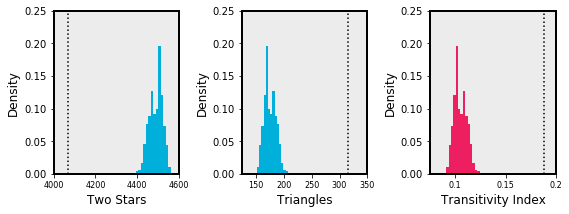

In [24]:
#-------------------------------------#
#- Histograms                        -#
#-------------------------------------#

# Define figure object
exact_test_fig, sbp = plt.subplots(ncols=3, figsize=(9, 3))
ax1 = sbp[0] # Handle for left subplot
ax2 = sbp[1] # Handle for middle subplot
ax3 = sbp[2] # Handle for right subplot

# Plot 1: Histogram of two star triads
plt.axes(ax1) # Select first subplot
plt.hist(Reference_TwoStar, bins=25, normed=False, weights=stb_iwgts, facecolor='#00B0DA', alpha=1, rwidth=1)
plt.plot((Nyakatoke_TwoStar, Nyakatoke_TwoStar), (0, 1), 'k:') # plot vertical line at x = # two stars in Nyakatoke

# Set axis limits 
plt.ylim([0,0.25])
plt.xlim([4000,4600])  

# Set tick labels
tick_locs = [4000, 4200, 4400, 4600]
tick_lbls = [4000, 4200, 4400, 4600]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Two Stars", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax1.patch.set_facecolor('gray')               # Color of background
ax1.patch.set_alpha(0.15)                     # Translucency of background
ax1.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('k')
    ax1.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=0.5)

# Plot 2: Histogram of triangle triads
plt.axes(ax2) # Select second subplot
plt.hist(Reference_Triangle, bins=25, normed=False, weights=stb_iwgts, facecolor='#00B0DA', alpha=1, rwidth=1)
plt.plot((Nyakatoke_Triangle, Nyakatoke_Triangle), (0, 1), 'k:') # plot vertical line at x = # triangles in Nyakatoke

# Set axis limits 
plt.ylim([0,0.25])
plt.xlim([125,350])  

# Set tick labels
tick_locs = [150, 200, 250, 300, 350]
tick_lbls = [150, 200, 250, 300, 350]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Triangles", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax2.patch.set_facecolor('gray')               # Color of background
ax2.patch.set_alpha(0.15)                     # Translucency of background
ax2.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_visible(True)
    ax2.spines[spine].set_color('k')
    ax2.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=0.5)

# Plot 3: Histogram of transitivity index
plt.axes(ax3) # Select third subplot
plt.hist(Reference_TI, bins=25, normed=False, weights=stb_iwgts, facecolor='#EE1F60', alpha=1, rwidth=1)
plt.plot((Nyakatoke_TI, Nyakatoke_TI), (0, 100), 'k:')      # plot vertical line at x = transitivity index in Nyakatoke

# Set axis limits 
plt.ylim([0,0.25])
plt.xlim([0.075,0.2])  

# Set tick labels
tick_locs = [0.10, 0.15, 0.20]
tick_lbls = [0.10, 0.15, 0.20]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Transitivity Index", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax3.patch.set_facecolor('gray')               # Color of background
ax3.patch.set_alpha(0.15)                     # Translucency of background
ax3.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax3.spines[spine].set_visible(True)
    ax3.spines[spine].set_color('k')
    ax3.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=0.5)

# Save figure
plt.savefig(graphics+'Triad_Census_%d_Trials.png' %S, bbox_inches='tight', dpi=500)     

In [25]:
print("Fraction of simulated networks which are connected: " + str(np.mean(Reference_Connected)))

Fraction of simulated networks which are connected: 0.9992


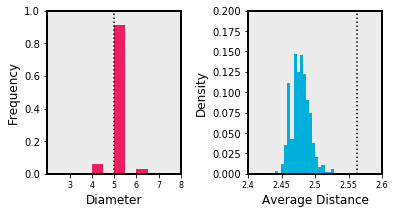

In [28]:
#-------------------------------------#
#- Histograms                        -#
#-------------------------------------#

# Define figure object
exact_test_fig, sbp = plt.subplots(ncols=2, figsize=(6, 3))
ax1 = sbp[0] # Handle for left subplot
ax2 = sbp[1] # Handle for right subplot

# Plot 1: Histogram of network diameter
plt.axes(ax1) # Select first subplot
plt.hist(Reference_Diameter, bins=6, normed=False, weights=stb_iwgts, facecolor='#EE1F60', alpha=1, rwidth=1)
plt.plot((Nyakatoke_Diameter, Nyakatoke_Diameter), (0, 1), 'k:') # plot vertical line at x = Diameter in Nyakatoke

# Set axis limits 
plt.ylim([0,1])
plt.xlim([2,8])  

# Set tick labels
tick_locs = [3, 4, 5, 6, 7, 8]
tick_lbls = [3, 4, 5, 6, 7, 8]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Diameter", fontsize=12)   
plt.ylabel("Frequency", fontsize=12)

# Clean up the plot, add frames etc.
ax1.patch.set_facecolor('gray')               # Color of background
ax1.patch.set_alpha(0.15)                     # Translucency of background
ax1.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('k')
    ax1.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=0.35)

# Plot 2: Histogram of network radius
plt.axes(ax2) # Select second subplot
plt.hist(Reference_AvgDis, bins=25, normed=False, weights=stb_iwgts, facecolor='#00B0DA', rwidth=1)
plt.plot((Nyakatoke_AvgDis, Nyakatoke_AvgDis), (0, 50), 'k:') # plot vertical line at x = Avergage Distance in Nyakatoke

# Set axis limits 
plt.ylim([0,0.2])
plt.xlim([2.4,2.6])  

# Set tick labels
tick_locs = [2.40,2.45,2.50,2.55,2.60]
tick_lbls = [2.40,2.45,2.50,2.55,2.60]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Average Distance", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax2.patch.set_facecolor('gray')               # Color of background
ax2.patch.set_alpha(0.15)                     # Translucency of background
ax2.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_visible(True)
    ax2.spines[spine].set_color('k')
    ax2.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=0.5)

# Save figure
plt.savefig(graphics+'Diameter_Distance_%d_Trials.png' %S, bbox_inches='tight', dpi=500)   

These final few snippets of code simulate a random draw from the set of cubic graphs on six nodes. It shows how links are added sequentially and the evolution of the residual degree sequence as the graph is built-up. A visual illustration of this process is also presented.

In [58]:
random_graph_with_fixed_degree([3,3,3,3,3,3])


Residual degree sequence: 
[2 2 3 3 3 3]

Current edge list
[(0, 1)]

Residual degree sequence: 
[1 2 3 3 2 3]

Current edge list
[(0, 1), (0, 4)]

Residual degree sequence: 
[0 2 2 3 2 3]

Current edge list
[(0, 1), (0, 4), (0, 2)]

Residual degree sequence: 
[0 1 2 3 2 2]

Current edge list
[(0, 1), (0, 4), (0, 2), (1, 5)]

Residual degree sequence: 
[0 0 2 2 2 2]

Current edge list
[(0, 1), (0, 4), (0, 2), (1, 5), (1, 3)]

Residual degree sequence: 
[0 0 1 2 1 2]

Current edge list
[(0, 1), (0, 4), (0, 2), (1, 5), (1, 3), (2, 4)]

Residual degree sequence: 
[0 0 0 2 1 1]

Current edge list
[(0, 1), (0, 4), (0, 2), (1, 5), (1, 3), (2, 4), (2, 5)]

Residual degree sequence: 
[0 0 0 1 0 1]

Current edge list
[(0, 1), (0, 4), (0, 2), (1, 5), (1, 3), (2, 4), (2, 5), (4, 3)]

Residual degree sequence: 
[0 0 0 0 0 0]

Current edge list
[(0, 1), (0, 4), (0, 2), (1, 5), (1, 3), (2, 4), (2, 5), (4, 3), (3, 5)]


[-4.7593208658153499,
 [(0, 1), (0, 4), (0, 2), (1, 5), (1, 3), (2, 4), (2, 5), (4, 3), (3, 5)]]

In [73]:
# Graph-in-hand
G = nx.Graph([(0,1),(0,4),(0,5),(1,2),(1,3),(2,3),(2,4),(3,5),(4,5)])
node_pos = {0: [0,2], 1: [0,1.35], 2: [-0.5,0.35], 3: [0.5,0.35], 4: [-1,0], 5: [1,0]} 

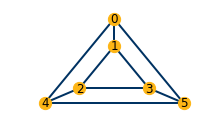

In [90]:
plt.figure(figsize=(3, 2))
nx.draw_networkx(G, pos = node_pos, with_labels=True, node_color='#FDB515', \
                     node_size = 150, \
                     edge_color='#003262', width=2)
plt.axis('off') 
ax.axes.set_xlim([-1.25,1.25])
ax.axes.set_ylim([-0.25,2.25])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Save result
plt.tight_layout()
plt.savefig(graphics+'blitzstein_diaconis_target_fig.eps', bbox_inches='tight', dpi=500)
plt.savefig(graphics+'blitzstein_diaconis_target_fig.png', bbox_inches='tight', dpi=500)

False


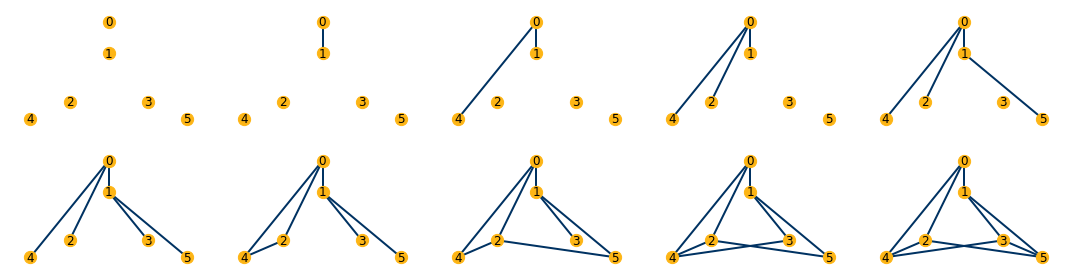

In [94]:
V=nx.Graph()                         
V.add_nodes_from(G)
V_edges = [(0, 1), (0, 4), (0, 2), (1, 5), (1, 3), (2, 4), (2, 5), (4, 3), (3, 5)]

print(nx.is_isomorphic(G, V))

blitzstein_diaconis_fig = plt.figure(figsize=(15, 4))

for edge in range(0,len(V_edges)+1):
    ax = 'ax'+str(edge)
    ax = blitzstein_diaconis_fig.add_subplot(2,5,edge+1)
  
    # Add current edge to Blitzstein and Diaconis simulated graph
    if edge>0:
        V.add_edge(*V_edges[edge-1])

    # Draw Isomorphism
    nx.draw_networkx(V, pos = node_pos, with_labels=True, node_color='#FDB515', \
                     node_size = 150, \
                     edge_color='#003262', width=2)
    
    plt.axis('off') 
    ax.axes.set_xlim([-1.25,1.25])
    ax.axes.set_ylim([-0.25,2.25])
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
        
    
# Save result
plt.tight_layout()
plt.savefig(graphics+'blitzstein_diaconis_simulation_fig.eps', bbox_inches='tight', dpi=500)
plt.savefig(graphics+'blitzstein_diaconis_simulation_fig.png', bbox_inches='tight', dpi=500) 